# Quenches in the PXP model

## In this example
- Constructing a constrained Hilbert space
- - Computing the Loschmidt echo and local observables
 
## Overview
We consider the PXP model with open boundary conditions. This is an example of a constrained Hilbert space, where two adjacent spins cannot both be spin up. References include Choi et al, arXiv:1812.05561, and Desaules et al, arXiv:2109.09724. 

The PXP Hamiltonian is given by 

$H = \Omega \sum_i P_{i-1} X_i P_{i+1}$, 

where 

$P_i = \frac{1 - Z_i}{2}$, the projector onto the ground state.

In the constrained hilbert space, this becomes 

$H = \Omega \sum_i P X_i P$, 

where $P$ is a global projector onto states without consecutive up-spins:

$P = \Pi_i (1 - (1 - P_i)(1 - P_{i+1}))$

We show how to build the subspace. We then show that this model exhibits proximate quantum many-body scars by quenching from the $\mathbb{Z}_2$ antiferromagnetic product state, where we measure the Loschmidt echo and magnetization.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from dynamite.operators import sigmax, sigmay, sigmaz, op_sum
from dynamite.states import State
from dynamite.subspaces import Explicit
from dynamite import config

# Building a constrained subspace in dynamite (Naive approach)

A naive approach is to loop over all bit-strings, and to only keep strings where there are no consecutive up-spins.

As an aside: If building the subspace becomes the bottleneck, we can make this faster by doing one (or more) level(s) of recursion.  

In [3]:
L = 16
config.L = L

subspace_str = []

for i in range(2**L):
    
    # convert this to a string of 0s and 1s
    bin_str = bin(i)[2:].zfill(L)
    if '11' not in bin_str:
        subspace_str.append(i)
        
subspace = Explicit(subspace_str)

config.subspace = subspace
config.allow_projection = True

# Proximate quantum many-body scars

We evolve the product state of alternating up and down spins under $H$.

In [4]:
Z2 = State(''.join(['1' if i%2 == 0 else '0' for i in range(L)]))

In [5]:
T = 10
num_ts = 51
ts = np.linspace(0, T, num_ts)

psi = Z2.copy()

lo_echo = np.zeros(num_ts)
mag_A = np.zeros(num_ts) # avg magnetization on even sites
mag_B = np.zeros(num_ts) # avg magnetization on odd sites

H = op_sum(sigmax(i) for i in range(L))
H.allow_projection = True 

dt = ts[1] - ts[0]

for t_idx, t in enumerate(ts):
    
    
    lo_echo[t_idx] = np.abs(Z2.dot(psi))**2
    
    mags = []
    for i in range(L):
        mags.append(psi.dot(sigmaz(i)*psi))
        
    mag_A[t_idx] = np.real(np.mean(mags[::2]))
    mag_B[t_idx] = np.real(np.mean(mags[1::2]))
    
    psi = H.evolve(psi, dt)

Text(0.5, 1.0, 'Loschmidt echo')

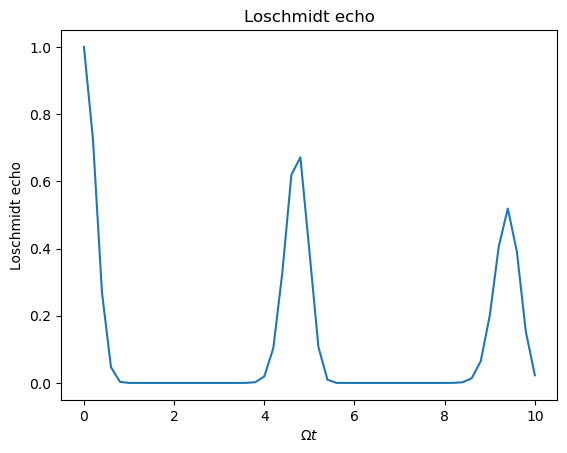

In [6]:
plt.plot(ts, lo_echo)

plt.xlabel('$\Omega t$')
plt.ylabel('Loschmidt echo')

plt.title('Loschmidt echo')

Text(0.5, 1.0, 'Average magnetization')

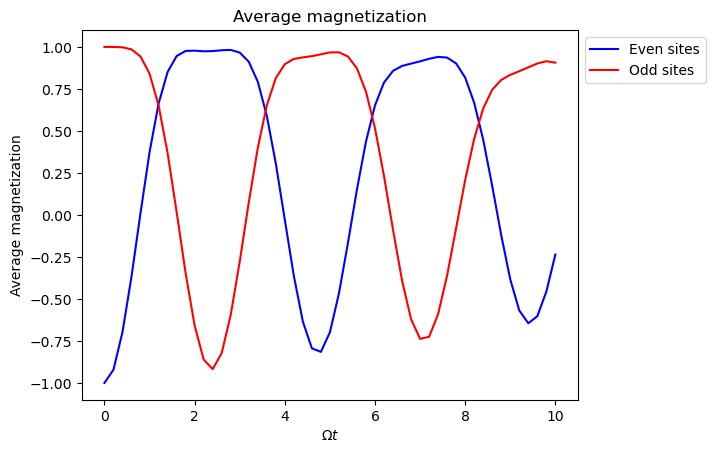

In [7]:
plt.plot(ts, mag_A, c='blue')
plt.plot(ts, mag_B, c='red')

plt.xlabel('$\Omega t$')
plt.ylabel('Average magnetization')
plt.legend(['Even sites', 'Odd sites'], bbox_to_anchor=[1, 1])
plt.title('Average magnetization')


We observe robust, albeit imperfect, revivals of the original state! This occurs because the initial state overlaps with "scar states," high-energy eigenstates of the Hamiltonian with low entropy. 

In contrast, suppose we began with the initial state of all down-spins.

In [8]:
all_down = State(''.join(['0' for _ in range(L)])) 

In [9]:
T = 10
num_ts = 51
ts = np.linspace(0, T, num_ts)

psi = all_down.copy()

lo_echo = np.zeros(num_ts)
mag_A = np.zeros(num_ts) # avg magnetization on even sites
mag_B = np.zeros(num_ts) # avg magnetization on odd sites

H = op_sum(sigmax(i) for i in range(L))
H.allow_projection = True
dt = ts[1] - ts[0]

for t_idx, t in enumerate(ts):
    
    lo_echo[t_idx] = np.abs(all_down.dot(psi))**2
    
    mags = []
    for i in range(L):
        mags.append(psi.dot(sigmaz(i)*psi))
        
    mag_A[t_idx] = np.real(np.mean(mags[::2]))
    mag_B[t_idx] = np.real(np.mean(mags[1::2]))
    
    psi = H.evolve(psi, dt)

Text(0.5, 1.0, 'Loschmidt echo')

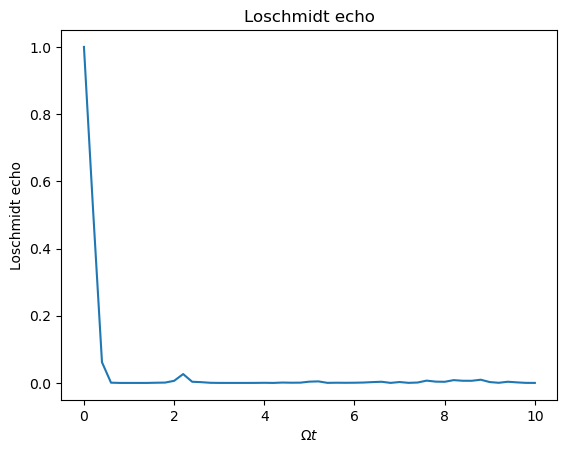

In [10]:
plt.plot(ts, lo_echo)

plt.xlabel('$\Omega t$')
plt.ylabel('Loschmidt echo')

plt.title('Loschmidt echo')

Text(0.5, 1.0, 'Average magnetization')

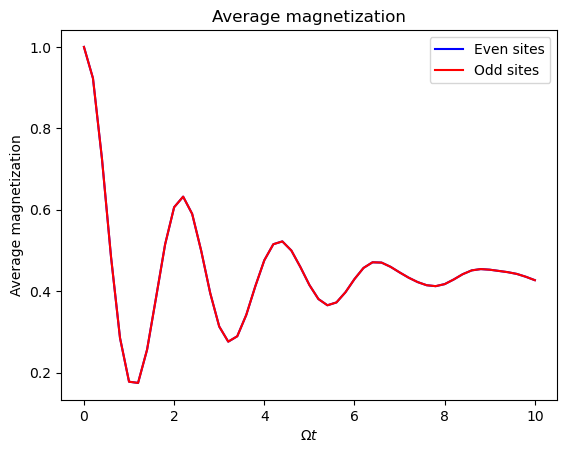

In [11]:
plt.plot(ts, mag_A, c='blue')
plt.plot(ts, mag_B, c='red')

plt.xlabel('$\Omega t$')
plt.ylabel('Average magnetization')
plt.legend(['Even sites', 'Odd sites'], bbox_to_anchor=[1, 1])
plt.title('Average magnetization')


Revivals are greatly suppressed!